<a href="https://colab.research.google.com/github/Ashrafalaghbari/Mutivariate-long-term-forecasting-of-oil-production/blob/main/multivariate_model_multistep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%autosave 60

Autosaving every 60 seconds


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Activation, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [4]:
!nvidia-smi

Sat Jan  7 16:07:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# check if GPU is utilized 
device_name = tf.config.experimental.list_physical_devices()[-1][-1]
if device_name != 'GPU':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(tf.test.gpu_device_name()))

Found GPU at: /device:GPU:0


In [6]:
# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale train and test data to [0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


# inverse differencing
def inverse_difference(history, interval=1):
	return history[-len(test_scaled)-interval:-interval]


In [7]:
#Evaluation metrics
# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result

# compute wMAPE weighted absolute percentage error
def wMAPE(actual, predicted): 
    result_nom = 0
    result_deno = 0
    for i in range(len(actual)):
        result_nom +=  abs(actual[i] - predicted[i])
        result_deno +=  abs(actual[i]) 
    result = result_nom/result_deno
    return result *100

def SMAPE(actual, predicted): #adjusted MEAN ABSOLUTE PERCENTAGE ERROR (SMAPE)
    result = 0
    for i in range(len(actual)):
        result += abs(actual[i] - predicted[i])/(abs(actual[i]) + abs(predicted[i]))
    result = 2* result/ len(actual) 
    return result * 100

In [ ]:
colum = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv')
colum.columns

In [8]:
#load dataset
series = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv',
                     usecols=["DATEPRD",'AVG_CHOKE_SIZE_P','AVG_DOWNHOLE_PRESSURE','AVG_DOWNHOLE_TEMPERATURE',
                              'ON_STREAM_HRS','AVG_WHP_P','AVG_WHT_P','F_4_BORE_WI_VOL','F_5_BORE_WI_VOL',
                              'DP_CHOKE_SIZE', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
                              "BORE_OIL_VOL"],
                  parse_dates=["DATEPRD"], index_col="DATEPRD")
#change the order of BORE_OIL_VOL
# series =series[["ON_STREAM_HRS",'BORE_GAS_VOL', 'BORE_WAT_VOL','AVG_CHOKE_SIZE_P','F_4_BORE_WI_VOL','F_5_BORE_WI_VOL',
                # "BORE_OIL_VOL"]] # chan

In [ ]:
recovery_time  = pd.Series(series.index.values).diff()
recovery_time = recovery_time.fillna(pd.Timedelta(days=1))
recovery_time = recovery_time.astype('string')
recovery_time  = recovery_time.str.extract(r'(\d+)')
recovery_time.index = series.index.values
series['recovery_time']  = recovery_time.astype('int')
series['recovery_time'] = series['recovery_time'] - 1

In [ ]:
shutin_days = pd.Series(index=series.index, dtype='int')
count = 0
for id,v in enumerate(series["ON_STREAM_HRS"]):
    
    if v == 0:
        shutin_days[id] = 0
        count+=1
        #continue
    else:
        shutin_days[id] = count
        count = 0

In [ ]:
series['shutin_days'] = shutin_days

In [ ]:
series.loc["2010-08-12":"2010-09-01"]

,ON_STREAM_HRS,BORE_GAS_VOL,BORE_WAT_VOL,AVG_CHOKE_SIZE_P,F_4_BORE_WI_VOL,F_5_BORE_WI_VOL,BORE_OIL_VOL,recovery_time,shutin_days
DATEPRD,,,,,,,,,
2010-08-12,24.00000,1.189315e+07,21979.051263,59.194010,41026.601139,42214.231030,14633.118565,0,0
2010-08-13,24.00000,1.189629e+07,22027.294110,59.199363,40552.473361,42752.254569,14629.659169,0,0
2010-08-14,24.00000,1.186412e+07,22003.770218,59.231621,40563.073975,42852.919662,14631.042927,0,0
2010-08-15,23.75833,1.155754e+07,21382.777218,57.292090,39495.791300,41199.828827,14332.528516,0,0
2010-08-17,0.00000,0.000000e+00,0.000000,0.000000,0.000000,24883.763848,0.000000,1,0
2010-08-20,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,2,0
2010-08-21,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
2010-08-22,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
2010-08-23,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0,0


In [9]:
column_to_move = series.pop("BORE_OIL_VOL")

# insert column with insert(location, column_name, column_value)

series.insert(len(series.columns), "BORE_OIL_VOL", column_to_move)

In [10]:
series.shape

(1844, 12)

In [ ]:
series.corr().iloc[:,-1] #200

ON_STREAM_HRS               0.429017
AVG_DOWNHOLE_PRESSURE      -0.514724
AVG_DOWNHOLE_TEMPERATURE    0.918395
AVG_CHOKE_SIZE_P           -0.067340
AVG_WHP_P                   0.247035
AVG_WHT_P                   0.426416
DP_CHOKE_SIZE               0.048679
BORE_GAS_VOL                0.996707
BORE_WAT_VOL                0.290599
F_4_BORE_WI_VOL             0.516457
F_5_BORE_WI_VOL             0.582626
BORE_OIL_VOL                1.000000
Name: BORE_OIL_VOL, dtype: float64

In [ ]:
# Data visulaization and disribution plots for well F-14 after including the injectors
data = series.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 28))

axs = axs.ravel()

for id, column in enumerate(data):

    axs[id].plot(series[column])
    axs[id].grid(True)
    axs[id].legend([column], loc='lower left', fontsize=9, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

**Multi-output forecasting strategy**

In [11]:
# # # convert series to stationary 
series_diff = series.copy()
diff_order = 1
series_diff['BORE_OIL_VOL'] = series_diff['BORE_OIL_VOL'].diff(diff_order)
# # convert the stationary series to supervise learning
timesteps = 10 # lag features
steps_ahead = 1
series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in=timesteps, n_out=steps_ahead, dropnan=True)

In [ ]:
agg[:10]

array([13290.87298265, 13287.91677167, 13258.29176374, 13290.24400159,
       13301.69145688, 13338.48684889, 13371.82284507, 13101.29809116,
       13088.0894889 , 13021.92068139])

In [ ]:
test_

In [ ]:
inv_y[:10]

array([ 1.64037002e+04,  1.59668100e+04,  1.49210661e+04,  1.49728312e+04,
        1.60726675e+04,  1.59135982e+04, -1.81898940e-12,  5.06442970e+03,
        1.46514848e+04,  1.66672433e+04])

In [ ]:
inv_yhat[:10]

array([16547.10784058, 16421.53423296, 16142.58344181, 16021.37957052,
       16176.92986801, 16287.35306359,  6842.38433945,  5001.91308594,
       11691.75196453, 16058.50336633])

In [ ]:
inv_yhat[:10]

array([16547.10784058, 16421.53423296, 16142.58344181, 16021.37957052,
       16176.92986801, 16287.35306359,  6842.38433945,  5001.91308594,
       11691.75196453, 16058.50336633])

In [ ]:
series[:10]

,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_GAS_VOL,BORE_WAT_VOL,F_4_BORE_WI_VOL,F_5_BORE_WI_VOL,BORE_OIL_VOL
DATEPRD,,,,,,,,,,,,
2010-01-01,24.00000,3378.643673,223.079164,50.150825,749.568621,190.264943,271.390953,1.462166e+07,15304.241356,44109.287732,49054.221066,18593.749401
2010-01-02,24.00000,3377.769461,223.095696,50.694654,744.664780,190.708397,266.368677,1.469266e+07,16519.118273,41936.969541,51515.296516,18701.242265
2010-01-03,24.00000,3408.561097,223.074953,47.665676,774.827418,192.268341,299.398157,1.400904e+07,14796.150455,41114.572918,51717.286427,17799.912406
2010-01-04,24.00000,3439.266918,223.022721,44.706230,806.160543,191.994925,333.246980,1.341015e+07,13428.619835,40267.292699,51948.640243,17002.616014
2010-01-05,24.00000,3429.064568,223.035833,45.743761,792.735696,191.503603,318.470614,1.361768e+07,9839.905499,40524.238503,52129.744099,17270.939334
2010-01-06,24.00000,3426.456339,223.052301,46.053981,787.778892,191.155238,313.483219,1.364834e+07,10054.073550,40733.215195,52212.108216,17331.761803
2010-01-07,24.00000,3432.314222,223.052885,44.740102,791.388814,190.547894,317.780795,1.350971e+07,12837.943721,39969.857579,51109.971510,17138.601719
2010-01-08,24.00000,3432.123127,223.061205,44.805229,788.842189,190.683690,315.702450,1.349732e+07,10488.510768,41079.035678,50933.111950,17127.657449
2010-01-09,22.83333,3492.820009,222.998368,39.728795,841.210210,186.402569,369.184766,1.192758e+07,10120.619746,26561.870164,36311.076594,14477.823141


In [ ]:
# pd.set_option('display.max_columns', None)
series_supervised.iloc[-len(test_y):]

NameError: ignored

In [ ]:
# # time-dependent variables 
# shifted_ON_STREAM_HRS = series_diff["ON_STREAM_HRS"].shift(-(timesteps + diff_order)).dropna()
# shifted_ON_STREAM_HRS.index = series_supervised.index.values 
# shifted_AVG_CHOKE_SIZE_P = series_diff['AVG_CHOKE_SIZE_P'].shift(-(timesteps + diff_order)).dropna()
# shifted_AVG_CHOKE_SIZE_P.index = series_supervised.index.values
# series_supervised = pd.concat([shifted_ON_STREAM_HRS,shifted_AVG_CHOKE_SIZE_P, series_supervised], axis=1) 

In [ ]:
# #drop all the variables that we don't want to predict
# vars_y = series_supervised.columns[-steps_ahead*len(series.columns):]
# vars_name_to_drop = ['ON_STREAM_HRS(t+)']
# vars_to_drop = vars_to_drop = [col for col in vars_y if col.startswith(vars_name_to_drop[0])]
# series_supervised.drop(columns=vars_to_drop, inplace=True)

In [ ]:
# # bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
# ON_STREAM_HRS_t = series_supervised.pop('ON_STREAM_HRS(t)')
# series_supervised.insert(len(series_supervised.columns)-1, 'ON_STREAM_HRS(t)', ON_STREAM_HRS_t)

In [13]:
merged_onStreams = series_supervised["ON_STREAM_HRS(t-1)"] + (series_supervised["ON_STREAM_HRS(t)"] ) #
# bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
series_supervised.insert(len(series_supervised.columns)-3, 'merged_onStreams', merged_onStreams)

In [12]:
merged_choke = series_supervised["AVG_CHOKE_SIZE_P(t-1)"] + (series_supervised["AVG_CHOKE_SIZE_P(t)"] ) #
# bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
series_supervised.insert(len(series_supervised.columns)-3, 'merged_choke', merged_choke)

In [14]:
merged_WI_F_4 = series_supervised["F_4_BORE_WI_VOL(t-1)"] + (series_supervised["F_4_BORE_WI_VOL(t)"] ) #
# bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
series_supervised.insert(len(series_supervised.columns)-3, 'merged_WI_F_4', merged_WI_F_4)

In [15]:
merged_WI_F_5 = series_supervised["F_5_BORE_WI_VOL(t-1)"] + (series_supervised["F_5_BORE_WI_VOL(t)"] ) #
# bring the ON_STREAM_HRS(t) variable forward one step and place it before the target variable
series_supervised.insert(len(series_supervised.columns)-3, 'merged_WI_F_5', merged_WI_F_5)

In [16]:
series_supervised.drop(['ON_STREAM_HRS(t-1)', 'AVG_CHOKE_SIZE_P(t-1)',"F_4_BORE_WI_VOL(t-1)",
                        "F_5_BORE_WI_VOL(t-1)"], axis=1, inplace= True)

In [17]:
series_supervised.drop(['AVG_CHOKE_SIZE_P(t)','ON_STREAM_HRS(t)','AVG_DOWNHOLE_PRESSURE(t)', 'AVG_DOWNHOLE_TEMPERATURE(t)',
                        'F_4_BORE_WI_VOL(t)','AVG_WHP_P(t)', 'AVG_WHT_P(t)', 'DP_CHOKE_SIZE(t)',
                        'F_5_BORE_WI_VOL(t)', 'BORE_GAS_VOL(t)', 'BORE_WAT_VOL(t)'], axis=1, inplace= True)


In [18]:
# # split into train and test sets
series_supervised = series_supervised.values
train_size = int(series_supervised.shape[0] * 0.8)
test_size = series_supervised.shape[0] - train_size
train, test = series_supervised[0:train_size], series_supervised[train_size:]
print(train.shape, test.shape)

(1466, 121) (367, 121)


In [19]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
print(train_scaled.shape, test_scaled.shape)

(1466, 121) (367, 121)


In [20]:
# # reshape input to be 3D [samples, timesteps, features]
n_features = len(series.columns) 

train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
train_X = train_X.reshape(train_X.shape[0], timesteps, n_features)
test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
test_X = test_X.reshape(test_X.shape[0], timesteps, n_features )
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1466, 10, 12) (1466, 1) (367, 10, 12) (367, 1)


In [32]:
import copy

In [33]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.random.set_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

# fit the model
neurons= [12]#12 
n_epochs=700#186

model = Sequential()
model.add(LSTM(neurons[0], activation="tanh", input_shape=(timesteps, n_features)))
model.add(Dense(steps_ahead)) # output layer
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# # early stopping to return the best model
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2, restore_best_weights=True, mode='min')
# save the best weights if training is interrupted
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min') 
#reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

# Set the initial validation loss to a large value
best_val_loss = float('inf')

# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 1200
loss_tracking = list()

# Run the training loop
for epoch in range(initial_epoch , n_epochs+1):
    print(f'Epoch {epoch}/{n_epochs}')
    # Train the model for one epoch
    history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save],
                    epochs=1, batch_size=2, validation_data=(test_X, test_y), verbose=2,
                     shuffle=False)
    # validation loss at each epoch
    validation_loss= model.evaluate(test_X, test_y, verbose=0)
    loss_tracking.append(validation_loss)

    # Save the model every 50 epochs
    if epoch % 10 == 0:
        model_saved = copy.deepcopy(model)
        # Load the best weights
        model_saved.load_weights(f'.mdl_wts.hdf5')
        # Get the validation loss for the best weights
        val_loss = model_saved.evaluate(test_X, test_y, verbose = 0)
          
        best_epoch = loss_tracking.index(val_loss) + 1
        # If the validation loss is the best so far, save the model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # Save the model  in HDF5 foramt with a filename that includes the epoch number
            model_saved = model_saved.save(f'best_model_{best_epoch}.h5')
            print(f'best_model_{best_epoch}')

Epoch 1/1200
733/733 - 4s - loss: 0.0167 - val_loss: 0.0048 - 4s/epoch - 6ms/step
Epoch 2/1200
733/733 - 2s - loss: 0.0103 - val_loss: 0.0043 - 2s/epoch - 3ms/step
Epoch 3/1200
733/733 - 2s - loss: 0.0082 - val_loss: 0.0038 - 2s/epoch - 3ms/step
Epoch 4/1200
733/733 - 2s - loss: 0.0070 - val_loss: 0.0033 - 2s/epoch - 3ms/step
Epoch 5/1200
733/733 - 3s - loss: 0.0062 - val_loss: 0.0028 - 3s/epoch - 3ms/step
Epoch 6/1200
733/733 - 2s - loss: 0.0057 - val_loss: 0.0024 - 2s/epoch - 3ms/step
Epoch 7/1200
733/733 - 2s - loss: 0.0053 - val_loss: 0.0021 - 2s/epoch - 3ms/step
Epoch 8/1200
733/733 - 2s - loss: 0.0049 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 9/1200
733/733 - 3s - loss: 0.0047 - val_loss: 0.0016 - 3s/epoch - 3ms/step
Epoch 10/1200
733/733 - 2s - loss: 0.0045 - val_loss: 0.0014 - 2s/epoch - 3ms/step


best_model_10
Epoch 11/1200
733/733 - 2s - loss: 0.0043 - val_loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 12/1200
733/733 - 2s - loss: 0.0041 - val_loss: 0.0012 - 2s/epoch - 3ms/step
Epoch 13/1200
733/733 - 3s - loss: 0.0039 - val_loss: 0.0011 - 3s/epoch - 3ms/step
Epoch 14/1200
733/733 - 3s - loss: 0.0038 - val_loss: 0.0011 - 3s/epoch - 3ms/step
Epoch 15/1200
733/733 - 2s - loss: 0.0036 - val_loss: 0.0011 - 2s/epoch - 3ms/step
Epoch 16/1200
733/733 - 3s - loss: 0.0035 - val_loss: 0.0011 - 3s/epoch - 3ms/step
Epoch 17/1200
733/733 - 2s - loss: 0.0034 - val_loss: 0.0011 - 2s/epoch - 3ms/step
Epoch 18/1200
733/733 - 2s - loss: 0.0033 - val_loss: 0.0011 - 2s/epoch - 3ms/step
Epoch 19/1200
733/733 - 2s - loss: 0.0032 - val_loss: 0.0011 - 2s/epoch - 3ms/step
Epoch 20/1200
733/733 - 3s - loss: 0.0031 - val_loss: 0.0011 - 3s/epoch - 3ms/step


best_model_17
Epoch 21/1200
733/733 - 2s - loss: 0.0030 - val_loss: 0.0011 - 2s/epoch - 3ms/step
Epoch 22/1200
733/733 - 2s - loss: 0.0029 - val_loss: 0.0011 - 2s/epoch - 3ms/step
Epoch 23/1200
733/733 - 2s - loss: 0.0028 - val_loss: 0.0011 - 2s/epoch - 3ms/step
Epoch 24/1200
733/733 - 2s - loss: 0.0027 - val_loss: 0.0012 - 2s/epoch - 3ms/step
Epoch 25/1200
733/733 - 2s - loss: 0.0027 - val_loss: 0.0012 - 2s/epoch - 3ms/step
Epoch 26/1200
733/733 - 2s - loss: 0.0026 - val_loss: 0.0012 - 2s/epoch - 3ms/step
Epoch 27/1200
733/733 - 3s - loss: 0.0025 - val_loss: 0.0012 - 3s/epoch - 4ms/step
Epoch 28/1200
733/733 - 2s - loss: 0.0025 - val_loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 29/1200
733/733 - 2s - loss: 0.0024 - val_loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 30/1200
733/733 - 2s - loss: 0.0024 - val_loss: 0.0013 - 2s/epoch - 3ms/step


Epoch 31/1200
733/733 - 2s - loss: 0.0024 - val_loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 32/1200
733/733 - 2s - loss: 0.0023 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 33/1200
733/733 - 2s - loss: 0.0023 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 34/1200
733/733 - 2s - loss: 0.0023 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 35/1200
733/733 - 2s - loss: 0.0022 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 36/1200
733/733 - 3s - loss: 0.0022 - val_loss: 0.0015 - 3s/epoch - 3ms/step
Epoch 37/1200
733/733 - 2s - loss: 0.0022 - val_loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 38/1200
733/733 - 2s - loss: 0.0021 - val_loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 39/1200
733/733 - 2s - loss: 0.0021 - val_loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 40/1200
733/733 - 2s - loss: 0.0021 - val_loss: 0.0015 - 2s/epoch - 3ms/step


Epoch 41/1200
733/733 - 2s - loss: 0.0021 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 42/1200
733/733 - 2s - loss: 0.0021 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 43/1200
733/733 - 2s - loss: 0.0020 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 44/1200
733/733 - 2s - loss: 0.0020 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 45/1200
733/733 - 2s - loss: 0.0020 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 46/1200
733/733 - 2s - loss: 0.0020 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 47/1200
733/733 - 2s - loss: 0.0020 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 48/1200
733/733 - 2s - loss: 0.0019 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 49/1200
733/733 - 2s - loss: 0.0019 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 50/1200
733/733 - 2s - loss: 0.0019 - val_loss: 0.0017 - 2s/epoch - 3ms/step


Epoch 51/1200
733/733 - 2s - loss: 0.0019 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 52/1200
733/733 - 2s - loss: 0.0019 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 53/1200
733/733 - 2s - loss: 0.0019 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 54/1200
733/733 - 2s - loss: 0.0019 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 55/1200
733/733 - 2s - loss: 0.0018 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 56/1200
733/733 - 2s - loss: 0.0018 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 57/1200
733/733 - 2s - loss: 0.0018 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 58/1200
733/733 - 2s - loss: 0.0018 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 59/1200
733/733 - 2s - loss: 0.0018 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 60/1200
733/733 - 2s - loss: 0.0018 - val_loss: 0.0018 - 2s/epoch - 3ms/step


Epoch 61/1200
733/733 - 2s - loss: 0.0018 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 62/1200
733/733 - 2s - loss: 0.0018 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 63/1200
733/733 - 2s - loss: 0.0017 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 64/1200
733/733 - 2s - loss: 0.0017 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 65/1200
733/733 - 3s - loss: 0.0017 - val_loss: 0.0018 - 3s/epoch - 3ms/step
Epoch 66/1200
733/733 - 3s - loss: 0.0017 - val_loss: 0.0018 - 3s/epoch - 3ms/step
Epoch 67/1200
733/733 - 2s - loss: 0.0017 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 68/1200
733/733 - 2s - loss: 0.0017 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 69/1200
733/733 - 2s - loss: 0.0017 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 70/1200
733/733 - 3s - loss: 0.0017 - val_loss: 0.0018 - 3s/epoch - 3ms/step


Epoch 71/1200
733/733 - 2s - loss: 0.0017 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 72/1200
733/733 - 2s - loss: 0.0017 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 73/1200
733/733 - 2s - loss: 0.0016 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 74/1200
733/733 - 2s - loss: 0.0016 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 75/1200
733/733 - 2s - loss: 0.0016 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 76/1200
733/733 - 2s - loss: 0.0016 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 77/1200
733/733 - 2s - loss: 0.0016 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 78/1200
733/733 - 2s - loss: 0.0016 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 79/1200
733/733 - 2s - loss: 0.0016 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 80/1200
733/733 - 2s - loss: 0.0016 - val_loss: 0.0018 - 2s/epoch - 3ms/step


Epoch 81/1200
733/733 - 2s - loss: 0.0016 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 82/1200
733/733 - 2s - loss: 0.0016 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 83/1200
733/733 - 2s - loss: 0.0016 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 84/1200
733/733 - 2s - loss: 0.0015 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 85/1200
733/733 - 2s - loss: 0.0015 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 86/1200
733/733 - 2s - loss: 0.0015 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 87/1200
733/733 - 3s - loss: 0.0015 - val_loss: 0.0017 - 3s/epoch - 4ms/step
Epoch 88/1200
733/733 - 2s - loss: 0.0015 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 89/1200
733/733 - 3s - loss: 0.0015 - val_loss: 0.0017 - 3s/epoch - 3ms/step
Epoch 90/1200
733/733 - 3s - loss: 0.0015 - val_loss: 0.0017 - 3s/epoch - 3ms/step


Epoch 91/1200
733/733 - 2s - loss: 0.0015 - val_loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 92/1200
733/733 - 2s - loss: 0.0015 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 93/1200
733/733 - 2s - loss: 0.0015 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 94/1200
733/733 - 2s - loss: 0.0015 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 95/1200
733/733 - 2s - loss: 0.0015 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 96/1200
733/733 - 2s - loss: 0.0015 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 97/1200
733/733 - 2s - loss: 0.0015 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 98/1200
733/733 - 2s - loss: 0.0015 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 99/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 100/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0016 - 2s/epoch - 3ms/step


Epoch 101/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 102/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 103/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 104/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 105/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 106/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 107/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 108/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 109/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 110/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0015 - 2s/epoch - 3ms/step


Epoch 111/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 112/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 113/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 114/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 115/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 116/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 117/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 118/1200
733/733 - 2s - loss: 0.0014 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 119/1200
733/733 - 2s - loss: 0.0013 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 120/1200
733/733 - 2s - loss: 0.0013 - val_loss: 0.0014 - 2s/epoch - 3ms/step


Epoch 121/1200
733/733 - 2s - loss: 0.0013 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 122/1200
733/733 - 2s - loss: 0.0013 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 123/1200
733/733 - 2s - loss: 0.0013 - val_loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 124/1200
733/733 - 2s - loss: 0.0013 - val_loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 125/1200
733/733 - 3s - loss: 0.0013 - val_loss: 0.0013 - 3s/epoch - 3ms/step
Epoch 126/1200
733/733 - 2s - loss: 0.0013 - val_loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 127/1200
733/733 - 2s - loss: 0.0013 - val_loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 128/1200
733/733 - 2s - loss: 0.0013 - val_loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 129/1200
733/733 - 2s - loss: 0.0013 - val_loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 130/1200
733/733 - 2s - loss: 0.0013 - val_loss: 0.0013 - 2s/epoch - 3ms/step


KeyboardInterrupt: ignored

In [24]:
model.load_weights(f'.mdl_wts.hdf5')

In [22]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.random.set_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

# fit the model
neurons= [12]#12 
n_epochs=700#186

model = Sequential()
model.add(LSTM(neurons[0], activation="tanh", input_shape=(timesteps, n_features)))
model.add(Dense(steps_ahead)) # output layer
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# # early stopping to return the best model
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2, restore_best_weights=True, mode='min')
# save the best weights if training is interrupted
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min') 
#reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

# Set the initial validation loss to a large value
best_val_loss = float('inf')

# # Set the initial and total number of epochs
# initial_epoch = 1
# n_epochs = 1200
# loss_tracking = list()


# Train the model for one epoch
history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save],
                epochs=n_epochs, batch_size=2, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)
# validation loss at each epoch
# validation_loss= model.evaluate(test_X, test_y, verbose=0)
# loss_tracking.append(validation_loss)


Epoch 1/700
733/733 - 4s - loss: 0.0167 - val_loss: 0.0048 - 4s/epoch - 6ms/step
Epoch 2/700
733/733 - 2s - loss: 0.0103 - val_loss: 0.0043 - 2s/epoch - 3ms/step
Epoch 3/700
733/733 - 3s - loss: 0.0082 - val_loss: 0.0038 - 3s/epoch - 3ms/step
Epoch 4/700
733/733 - 2s - loss: 0.0070 - val_loss: 0.0033 - 2s/epoch - 3ms/step
Epoch 5/700
733/733 - 2s - loss: 0.0062 - val_loss: 0.0028 - 2s/epoch - 3ms/step
Epoch 6/700
733/733 - 2s - loss: 0.0057 - val_loss: 0.0024 - 2s/epoch - 3ms/step
Epoch 7/700
733/733 - 2s - loss: 0.0053 - val_loss: 0.0021 - 2s/epoch - 3ms/step
Epoch 8/700
733/733 - 2s - loss: 0.0049 - val_loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 9/700
733/733 - 3s - loss: 0.0047 - val_loss: 0.0016 - 3s/epoch - 4ms/step
Epoch 10/700
733/733 - 3s - loss: 0.0045 - val_loss: 0.0014 - 3s/epoch - 3ms/step
Epoch 11/700
733/733 - 2s - loss: 0.0043 - val_loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 12/700
733/733 - 2s - loss: 0.0041 - val_loss: 0.0012 - 2s/epoch - 3ms/step
Epoch 13/700
733/733 - 2s

KeyboardInterrupt: ignored

In [34]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K
tf.random.set_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

# fit the model
neurons= [112]#12 
n_epochs=700#186

model = Sequential()
model.add(LSTM(neurons[0], activation="tanh", input_shape=(timesteps, n_features)))
model.add(Dense(steps_ahead)) # output layer
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# # early stopping to return the best model
early_stopping = EarlyStopping(monitor='loss', patience=2, verbose=2, restore_best_weights=True, mode='min')
# save the best weights if training is interrupted
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min') 
#reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

# Set the initial validation loss to a large value
best_val_loss = float('inf')

# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 1200
loss_tracking = list()

# Run the training loop

# Train the model for one epoch
history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save],
                epochs=1, batch_size=2, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)

KeyboardInterrupt: ignored

In [26]:
# restore the model
import tensorflow as tf
# model = tf.keras.models.load_model('best_model_10.h5')
scores = model.evaluate(test_X, test_y, verbose=0)
scores # validation loss for the saved model

0.0004244557931087911

In [ ]:
# # continue training if interrupted 

# model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

# # # early stopping to return the best model
# early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2, restore_best_weights=True, mode='min')
# # save the best weights if training is interrupted
# mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min') 
# #reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

# # Set the initial validation loss to a large value
# best_val_loss = float('inf')

# # Set the initial and total number of epochs
# initial_epoch = 1
# n_epochs = 20
# loss_tracking = list()

# # Run the training loop
# for epoch in range(initial_epoch , n_epochs+1):
#     print(f'Epoch {epoch}/{n_epochs}')
#     # Train the model for one epoch
#     history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save],
#                     epochs=1, batch_size=2, validation_data=(test_X, test_y), verbose=2,
#                      shuffle=False)
#     # validation loss at each epoch
#     validation_loss= model.evaluate(test_X, test_y, verbose=0)
#     loss_tracking.append(validation_loss)

#     # Save the model every 10 epochs
#     if epoch % 10 == 0:
#         # Load the best weights
#         model.load_weights(f'.mdl_wts.hdf5')
#         # Get the validation loss for the best weights
#         val_loss = model.evaluate(test_X, test_y, verbose = 0)
          
#         best_epoch = loss_tracking.index(val_loss) + 1
#         # If the validation loss is the best so far, save the model
#         if val_loss < best_val_loss:
#             # Save the model  in HDF5 foramt with a filename that includes the epoch number
#             model.save(f'best_model_{best_epoch}.h5')
#             print(f'best_model_{best_epoch}')

In [126]:
# # Print the learning rate of the optimizer
# print(f'Learning rate: {model.optimizer.learning_rate.numpy()}')
# # # Check the epoch at which the best weights were saved
# print(f'Best weights using early stop {early_stopping.best} (loss) were saved at epoch {(early_stopping.best_epoch +1)}')
# # Evaluate the model on the test set
# scores = model.evaluate(test_X, test_y, verbose=0)
# print(f'Best weights using model check point {scores} were saved at epoch {(best_epoch)}')

Learning rate: 9.999999747378752e-05
Best weights using early stop 0.003111298196017742 (loss) were saved at epoch 1
Best weights using model check point 0.001432529534213245 were saved at epoch 15


In [ ]:
# 0.00024551700334995985 all variables 6 times steps
# 4.2105e-04 all variables 4 times steps

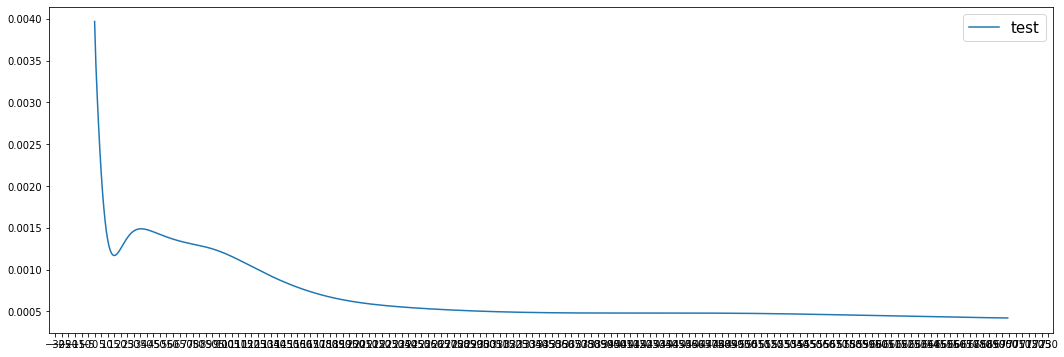

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
#plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(fontsize=15)
plt.show()

**MinMax Scaler equation**
$$x' = \frac{(x - min)}{(max - min)} \times (new\ max\ value - new\ min\  value) + new\ min\ value$$<br/>


$$x = \frac{(max - min)\times (new\ min\ value + x') + (new\ max\ value - new\ min\ value)\times min}{new\ max\ value - new\ min\ value}$$

Where:

$x$ is the inverse scaled value
$x'$ is the scaled value
$min$ is the minimum value of the original data
$max$ is the maximum value of the original data.<br/>
$new\ max\ value$ and $new\ min\ value$ is the new range that we want to scale the data to. For example: $(1,0)\ or\ (1,-1)$

In [ ]:
# make a prediction 
# select the number of obersvtions for prediction
n_obs = len(test)
yhat = model.predict(test_X[-n_obs:], verbose=1)


# invert scaling 
scaled_y = pd.DataFrame(test_y)
scaled_yhat = pd.DataFrame(yhat.ravel()) ## ravel () converting into 1D array
#obtain the min and max from the training set
unscaled_train = pd.DataFrame(series_supervised[:len(train)])
#new feature range
new_max_value = 1 
new_min_value= 0
feature_range = new_max_value - new_min_value

def transform_column(column):
    min_value = min(unscaled_train.iloc[:, -steps_ahead + column.name])
    max_value = max(unscaled_train.iloc[:, -steps_ahead + column.name])
    return ((max_value - min_value) * (new_min_value + column) + (feature_range  * min_value)) / feature_range 
    
# invert scaling for actual
inv_scale_y = scaled_y.apply(transform_column, axis=0)
inv_scale_y = inv_scale_y.values.ravel() 
# invert scaling for forecast
inv_scale_yhat = scaled_yhat.apply(transform_column, axis=0)
inv_scale_yhat = inv_scale_yhat.values.ravel()

12/12 [==============================] - 1s 2ms/step


In [ ]:
test_X[-n_obs:].shape

(368, 7, 12)

In [ ]:
pd.DataFrame(inv_scale_y)

,0
0,-645.145873
1,-436.890244
2,-1045.743910
3,51.765141
4,1099.836282
5,-159.069310
6,-15913.598207
7,5064.429699
8,9587.055113
9,2015.758501


In [ ]:
pd.DataFrame(inv_scale_yhat)

,0
0,3421.333008
1,3349.463867
2,3328.709961
3,3329.249023
4,3238.881836
...,...
75,2114.317383
76,2724.540039
77,2556.254883
78,1916.452148


In [ ]:
pd.DataFrame(inv_scale_yhat)

,0
0,16090.043945
1,17022.681641


In [ ]:
pd.DataFrame(inv_scale_yhat)

,0
0,16130.116211
1,17011.335938


In [ ]:
# Invert the Differencing for actual 
df = pd.DataFrame(series.iloc[-len(test)-steps_ahead:,-1])
n_vars = df.shape[1]
columns = df.columns
cols, names = list(), list()
for i in range(0, steps_ahead):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
    else:
        names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
# put it all together
agg = pd.concat(cols, axis=1)
agg.columns = names
agg.dropna(inplace=True)
agg = agg.iloc[:-1,0]
#drop all the variables that we don't want to predict
#agg.drop(columns=vars_to_drop, inplace=True)
agg = agg.to_numpy()
inv_y = np.add(inv_scale_y,agg)

* To invert the differencing of time series for multistep prediction:<br/>
The equation is given by $$
\hat x_{t+h|t}=x_t+(\widehat{\Delta x_{t+1}}+\dots+\widehat{\Delta x_{t+h}}).
$$ <br/>
where: <br/>
$\hat x_{t+h|t}$ is the predicted value of the time series x at time $t$+h, given the value of the time series at time $t$.<br/>
$x_t$ is the value of the time series $x$ at time t.<br/>
${\Delta x_{t+1}}$ is the difference between the value of the time series $x$ at time $t+1$ and the value of the time series at time t.<br/>
${\Delta x_{t+2}}$ is the difference between the value of the time series $x$ at time $t+2$ and the value of the time series at time $t+1$.<br/>
${\Delta x_{t+h}}$ is the difference between the value of the time series $x$ at time $t+h$ and the value of the time series at time $t+h-1$.

In [ ]:
# Invert the Differencing for forecast
# to invert the diffrenced predicted values,the the predicted differenced value is added
# to previous predicted diffenced values and last available observation in test set(Xt) as explained above
originalSeries_supervised = series_to_supervised(series, series.columns, n_in=timesteps, n_out=steps_ahead, dropnan=True)

current_timestep = 1
# actual value of oil rate at current time step
# steps_ahead = 4
#drop all the variables that we don't want to predict
vars_y = originalSeries_supervised.columns[-steps_ahead*len(series.columns):]
vars_to_drop = [col for col in vars_y if col.startswith(vars_name_to_drop[0])]
originalSeries_supervised.drop(columns=vars_to_drop, inplace=True)
originalSeries_xt = originalSeries_supervised.iloc[-len(test):,-steps_ahead-2]


# A predicted value at any given step ahead is a result of the previous cumulative differnced predicted values and current time step
col = []
#inv_yhat_cum = np.cumsum(inv_scale_yhat, axis=1)
inv_yhat_cum = inv_scale_yhat

for i in range(n_obs):
    #.ravel() flattens the series into a one-dimensional array
    inverted_diff_yhat = originalSeries_xt[-n_obs:].ravel()[i] + inv_yhat_cum[i]
    col.append(inverted_diff_yhat)
#col = pd.DataFrame.from_records(col) # creates a DataFrame from a list of records
col = pd.DataFrame(col)
#col.columns = pd.RangeIndex(start=1, stop=steps_ahead+1, step=1)
inv_yhat = col.values.ravel() # convert df to NumpyArray

In [ ]:
inv_yhat = np.add(inv_scale_yhat,agg)

In [ ]:
inv_y[:10]

array([3400.90059142, 1902.73060461, 2717.82716026,  672.44365125,
         61.70304199, 3062.1313925 , 1036.43499067, 2522.33984681,
        885.22794384, 3063.89253947])

In [ ]:
inv_yhat[:10] 

array([3607.93342036, 2350.85371642, 3257.16322179, 1183.83887901,
        126.939745  , 3499.08097167, 1843.84037688, 3750.63127973,
       1881.272464  , 3321.59024853])

In [ ]:
inv_yhat[:10] 

array([3590.59357661, 2211.30977111, 3251.55189367, 1095.77833214,
        381.24345593, 3312.50870605, 1757.93412688, 3445.83049848,
       1839.522464  , 3686.42227978])

In [ ]:
inv_yhat[:10] 

array([3594.66193598, 2206.2423883 , 3173.63001867, 1143.65919151,
        407.15947156, 3368.39737792, 1757.37943938, 3290.52971723,
       1995.08789369, 3455.65079541])

In [ ]:
inv_yhat[:10] 

array([3626.33967036, 2268.59590392, 3209.46400304, 1201.12501182,
        361.57548718, 3662.83683105, 1867.23881438, 3091.02581098,
       2142.52344056, 3604.08829541])

In [ ]:
inv_yhat[:10] 

array([3434.46857661, 3391.58027892, 1893.50794836, 2708.45704307,
        663.33622937,   53.39640136, 3052.82279875, 1027.26409223,
       2513.01269837,  876.16739697])

In [ ]:
inv_yhat[:10] 

array([3616.66779536, 2901.4142633 , 2707.84290929, 2021.48536339,
        415.11064343, 2041.42862792, 2893.83940032, 1935.12932661,
       2185.30762025, 2642.25040478])

In [ ]:
inv_yhat[:10] 

array([3574.35529536, 2202.53340392, 3130.52064367,  958.16505089,
          4.90165906, 2767.44425292, 1848.91557219, 3947.85198286,
       1786.16992494, 3531.10392041])

In [ ]:
inv_yhat[:10] 

array([3636.01545161, 2339.25898986, 3426.80189367, 1147.14063682,
        288.00908093, 3820.93644042, 2009.1470175 , 3904.13713911,
       1911.25879212, 3662.91837353])

In [ ]:
inv_yhat[:10] # 1 time steps # on stream choke

array([3381.95099848, 1601.08223205, 3568.13392492, -203.34080849,
       -564.89033313, 5612.03995605, 2615.65483   , 3544.03557661,
       1119.57129212, 3880.51602978])

In [ ]:
inv_yhat[:10] # 4 time steps # on stream choke

array([3362.01447504, 3014.15742736, 1575.44740148, 2900.26856651,
        196.33037   ,  969.9657373 , 4537.10893157, 1709.12542036,
       2967.28906556, 1227.26407666])

In [ ]:
inv_yhat[:10]# 4 time steps # on stream

array([3357.58478754, 3198.6486383 , 1894.60365148, 2831.45606651,
        624.30595593,  780.4735498 , 3790.01518157, 1856.40471723,
       3131.147464  , 1301.48477978])

In [ ]:
r2_score(inv_y,inv_yhat)

0.31858047240881304

In [ ]:
wMAPE(inv_y[:10],inv_yhat[:10])

28.446741757485977

In [ ]:
inv_y.shape, inv_yhat.shape

((369,), (369,))

In [ ]:
# Performance evaluation

rmse_test = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.5f' % rmse_test)
#report performance using RMSPE
RMSPE_test = RMSPE(inv_y, inv_yhat)
print('Test RMSPE: %.5f' % RMSPE_test)
MAE_test = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.5f' % MAE_test)
MAPE_test = MAPE(inv_y, inv_yhat)
print('Test MAPE: %.5f' % MAPE_test)
r2 = r2_score(inv_y, inv_yhat)
print('Test r2: %.5f' % r2)
wMAPE_test = wMAPE(inv_y, inv_yhat)
print('Test wMAPE: %.5f ' % wMAPE_test)
SMAPE_test = SMAPE(inv_y, inv_yhat)
print('Test wMAPE: %.5f ' % SMAPE_test)

Test RMSE: 449.03130
Test RMSPE: 19544194831094544.00000
Test MAE: 213.63827
Test MAPE: 1353133045674894.00000
Test r2: 0.60894
Test wMAPE: 9.53361 
Test wMAPE: 14.70437 


In [ ]:
# Performance evaluation
rmse_test, RMSPE_test, MAE_test, MAPE_test, r2_test, wMAPE_test, SMAPE_test  = [], [], [], [], [], [], []
# calculate the score for each day

for i in range(test_y.shape[1]):
    result_rmse = sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i]))
    result_RMSPE = RMSPE(inv_y[:,i], inv_yhat[:,i])
    result_MAE = mean_absolute_error(inv_y[:,i], inv_yhat[:,i])
    result_MAPE = MAPE(inv_y[:,i], inv_yhat[:,i])
    result_r2 = r2_score(inv_y[:,i], inv_yhat[:,i])
    result_wMAPE = wMAPE(inv_y[:,i], inv_yhat[:,i])
    result_SMAPE = SMAPE(inv_y[:,i], inv_yhat[:,i])

    rmse_test.append(result_rmse)
    RMSPE_test.append(result_RMSPE)
    MAE_test.append(result_MAE)
    MAPE_test.append(result_MAPE)
    r2_test.append(result_r2)
    wMAPE_test.append(result_wMAPE)
    SMAPE_test.append(result_SMAPE)
    
## calculate overall score
print("The Average scores for the vector output {} steps ahead:\n".format(steps_ahead))
print('Test RMSE: %.5f' % np.mean(rmse_test))
#print('Test RMSPE: %.5f' % np.mean(RMSPE_test)) because of that the denominator (actual) has some zero values
print('Test MAE: %.5f' % np.mean(MAE_test))
#print('Test MAPE: %.5f' % np.mean(MAPE_test)) because of that the denominator (actual) has some zero values
print('Test r2: %.5f' % np.mean(r2_test))
print('Test wMAPE: %.5f ' % np.mean(wMAPE_test))
print('Test SMAPE: %.5f ' % np.mean(SMAPE_test))

IndexError: ignored

In [ ]:
Test RMSE: 555.56135
Test MAE: 277.11301
Test r2: 0.39641
Test wMAPE: 12.32902 
Test SMAPE: 17.45901

In [ ]:
# plot the scores for each time step of the multi-step forecast
scores = pd.DataFrame({"rmse_test":rmse_test, "MAE_test":MAE_test, "R-squared_test":r2_test, "wMAPE_test":wMAPE_test, "SMAPE_test":SMAPE_test})

# Reset the index, keeping the old index as a column
scores = scores.reset_index(drop=False)

# Set the 'index' column as the new index
scores.index = scores['index'] + 1

# Drop the old 'index' column
scores = scores.drop(columns='index')

data = scores.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 15))

axs = axs.ravel()

for id, column in enumerate(data):
    # Set the x-axis limits
    #axs[id].set_xlim(xmin=1, xmax= steps_ahead)
    #print the name of the test on plot
    axs[id].plot(scores[column])
    # Add a title to the x-axis
    axs[id].set_xlabel('Steps ahead',fontsize=10, labelpad=0.1)
    axs[id].grid(True)
    # Remove the horizontal grid lines
    axs[id].grid(which='both', axis='y')
    axs[id].xaxis.set_major_locator(plt.MultipleLocator(1))
    axs[id].legend([column], loc='upper left', fontsize=15, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

In [ ]:
inv_yhat

In [ ]:
inv_yhat[-1]

In [ ]:
plt.plot(inv_yhat[-1], label = "predicted")
plt.plot(inv_y[-1], label = "actual")

In [ ]:
plt.plot(inv_yhat.flatten(), label = "predicted")
plt.plot(inv_y.flatten(), label = "actual")

In [ ]:
plt.plot(inv_yhat.flatten(), label = "predicted")
plt.plot(inv_y.flatten(), label = "actual")

In [ ]:
# plot the last forecasted values on test set
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
# Set the major locator for the x-axis
x = list(range(1, len(inv_yhat[-1])+1))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.plot(x, inv_yhat[-1], label = "predicted")
ax.plot(x, inv_y[-1], label = "actual")
ax.set_ylabel('Oil Rate', fontsize=15)
ax.set_xlabel('Steps Ahead (Days)',fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
#comparing predictions and actual values
act_pred = pd.DataFrame({"actual":inv_y.flatten(), "prediction":inv_yhat.flatten()})
act_pred.head(5)

In [ ]:
series_to_supervised(series, series.columns, n_in=2, n_out=steps_ahead, dropnan=True).iloc[-len(test):-len(test)+5]

In [ ]:
r2_score(act_pred.iloc[:5,0],act_pred.iloc[:5,1])

In [ ]:
wMAPE(act_pred.iloc[:5,0],act_pred.iloc[:5,1])

In [ ]:
MAPE(act_pred.iloc[:5,0],act_pred.iloc[:5,1])